# Correcting the near bottom velocity field using FVCOM data

In [12]:
import os 
import configparser
import pathlib

from pylag.grid_metrics import create_fvcom_grid_metrics_file

import datetime
from pylag.fvcom_data_reader import FVCOMDataReader
from pylag.mediator import SerialMediator

In [8]:
FVCOM_DIR='/home/abolmaal/Data/FVCOMEDATA'.format(os.environ['HOME']) 

# Create run directory
cwd = os.getcwd()
# Create run directory
MODELLING_DIR = '/home/abolmaal/modelling/FVCOM/Huron'.format(cwd)
try:
    os.makedirs(MODELLING_DIR)
except FileExistsError:
    pass


# Create input sub-directory for input files
input_dir = '{}/input'.format(MODELLING_DIR)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass


# input file to create grid metrics
fvcom_file_name = os.path.join(FVCOM_DIR, '202301','nos.lmhofs.fields.n000.20230101.t00z.nc')

# The file listing the location of open boundary nodes

obc_file_name = os.path.join(MODELLING_DIR,'input', 'obc.dat')



# initial position of the particles
initial_position_file = os.path.join(FVCOM_DIR, 'input', 'initial_positions_releasezone_intersection_multigroup.dat')


# config file
config_file_name = os.path.join(MODELLING_DIR, 'config_files', 'Huron_Senseflux_Seasonal_test.cfg')


In [3]:
#The name of the output file containing the grid metrics
# create a sub directory for the grid file
grid_file_dir = f'{input_dir}/gridfile'
try:
    os.makedirs(grid_file_dir)
except FileExistsError:
    pass
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

#grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
# Create output sub-directory

output_dir = '{}/output'.format(MODELLING_DIR)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [4]:
# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.

Calculating element areas ... done
Grid has 51110 nodes on the open boundary


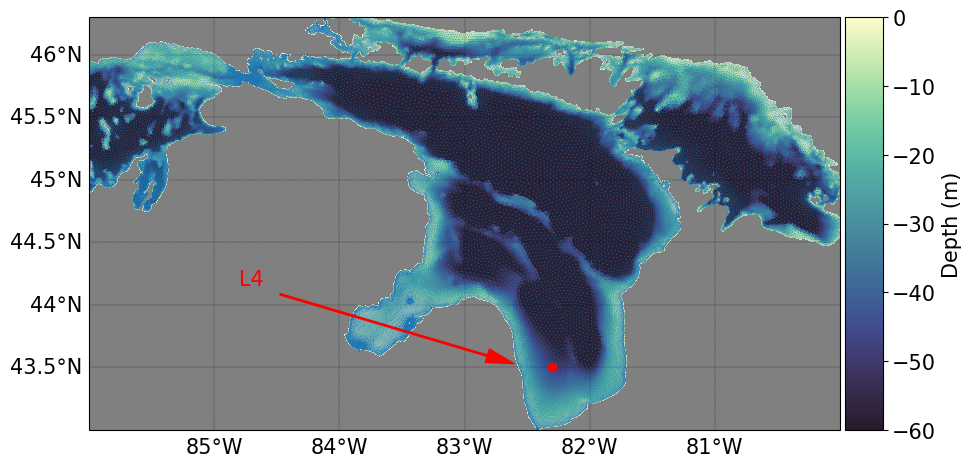

In [42]:
import warnings
import numpy as np
import matplotlib
from netCDF4 import Dataset
import cartopy.crs as ccrs

# Ensure inline plotting
%matplotlib inline

from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap
# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(),
                        font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
extents = np.array([274, 280, 43,46.3], dtype=float)
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=0.1)

# Mark location of Station L4
plotter.scatter(ax, [-82.3], [43.5], marker='o', c='r')
x, y = ax.projection.transform_point(-82.5, 43.5, src_crs=ccrs.PlateCarree())
label = ax.annotate('L4', xy=(x, y), xytext=(0.2, 0.35), textcoords='axes fraction',
             arrowprops=dict(facecolor='red', edgecolor='red', width=1, headwidth=10, headlength=20, shrink=0.05),
             fontsize=font_size, color='red')

In [75]:
data_dir = os.path.join(FVCOM_DIR, '202301')
grid_metrics_file_name

'/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

In [82]:
# Create config
config = configparser.ConfigParser()
config.add_section('SIMULATION')
config.set('SIMULATION', 'coordinate_system', 'geographic')
config.add_section('OCEAN_DATA')
config.set('OCEAN_DATA', 'name', 'FVCOM')
config.set('OCEAN_DATA', 'data_dir', f'{data_dir}')
config.set('OCEAN_DATA', 'grid_metrics_file', f'{grid_metrics_file_name}')
config.set('OCEAN_DATA', 'data_file_stem', 'nos.lmhofs.fields.n000.')
config.set('OCEAN_DATA', 'rounding_interval', '3600')
config.set('OCEAN_DATA', 'Kz_method', 'none')
config.set('OCEAN_DATA', 'Ah_method', 'none')
config.set('OCEAN_DATA', 'has_is_wet', 'True')
config.set('OCEAN_DATA','use_near_bottom_log_velocity_profile', 'False')
# Extra options to help the config pass PyLag's internal checks
config.add_section('NUMERICS')
config.set('NUMERICS', 'num_method', 'test')
config.set('NUMERICS', 'time_step_adv', '1')

In [83]:
datetime_start = datetime.datetime(2023,1,2,0)
datetime_end = datetime.datetime(2023,1,2,22)

To reconstruct a velocity profile, we use PyLag’s Particle class to create a particle object. We then vary the position of this particle, and use PyLag’s FVCOMDataReader to compute the velocity at the particle’s position. We use PyLag’s Python API to accomplish this.

In [85]:
import numpy as np

from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.data_types_python import DTYPE_FLOAT


def compute_current_profile(apply_log_correction):
    """ Generate the velocity profile

    Parameters
    ----------
    apply_log_correction: bool
     Boolean indicating whether the log correction should be applied or not. True or False

    Returns
    -------
    depth_arr: NetCDF array
        Depth array

    speed_arr: NetCDF array
        Current speed array
    """
    if apply_log_correction:
        config.set('OCEAN_DATA', 'apply_near_bottom_log_velocity_profile', 'True')
        config.set('OCEAN_DATA', 'z0', '1.e-4')
    else:
        config.set('OCEAN_DATA', 'apply_near_bottom_log_velocity_profile', 'False')

    # Create a mediator object, which controls file access
    mediator = SerialMediator(config, 'ocean', datetime_start, datetime_end)

    # Create the FVCOM data reader
    data_reader = FVCOMDataReader(config, mediator)

    # Set location to Station L4. Internally, PyLag stored particle positions
    # in radians, so we convert these here. NB - this is different to how positions
    # are speficied in the initial positions file.
    
    x1 = -82.5 * np.radians(0.1)
    x2 = 43.5 * np.radians(0.1)

    # Create a particle object
    particle = ParticleSmartPtr(x1=x1, x2=x2)

    # Determine the host horizontal element - needed for interpolating the velocity field
    flag = data_reader.find_host_using_global_search_wrapper(particle)

    if flag != 0:
        raise RuntimeError('Failed to locate the particle')

    # Define the time at which we want to compute the velocity profile
    datetime_now = datetime.datetime(2023,1,2,20)
    # Convert the time to seconds since the start of the simulation
    # This is needed for the FVCOM data reader
    time = (datetime_now - datetime_start).total_seconds()

    # Read data for the current time
    data_reader.read_data(time)

    # Compute the water depth and the sea surface height at the particle's spatiotemporal coordinates
    h = data_reader.get_zmin_wrapper(time, particle)
    zeta = data_reader.get_zmax_wrapper(time, particle)

    # Define a vertical grid of points between h and zeta
    n_depths =  1000
    depth_arr = np.linspace(h, zeta, n_depths)

    # Create a profile of the current speed
    current_speed_arr = np.empty_like(depth_arr)
    for i in range(n_depths):

        # Update the depth of the particle
        particle.x3 = depth_arr[i]

        # Set vertical interpolation coefficients
        if data_reader.set_vertical_grid_vars_wrapper(time, particle) != 0:
            raise RuntimeError('Failed to set vertical grid variables')

        # Compute the velocity at the particle's spatiotemporal coordinates
        vel = np.empty(3, dtype=DTYPE_FLOAT)
        data_reader.get_velocity_wrapper(time, particle, vel)

        # Compute speed from the horizontal component only
        current_speed_arr[i] = np.sqrt(vel[0]**2 + vel[1]**2)

    return depth_arr, current_speed_arr, h, zeta

# No correction
z_not_corrected, curr_not_corrected, h, zeta = compute_current_profile(False)

# With correction
z_corrected, curr_corrected, _, _ = compute_current_profile(True)

RuntimeError: Failed to locate the particle